In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

In [2]:
# Paths
project_root = r"C:/Graduation Project/AI_Cybersecurity"
processed_path = os.path.join(project_root, "Data", "Processed")
models_path = os.path.join(project_root, "Models")

In [3]:
# Load preprocessed data
iso_preds = joblib.load(os.path.join(models_path, "iso_preds.pkl"))
autoencoder = load_model(
    os.path.join(models_path, "autoencoder.keras"),
    custom_objects={"mse": MeanSquaredError()}
)
ae_preds  = joblib.load(os.path.join(models_path, "ae_preds.pkl"))   #reconstruction errors
y_test    = joblib.load(os.path.join(processed_path, "test_labels.pkl"))

In [4]:
print(pd.Series(y_test).value_counts())
print(pd.Series(y_test).value_counts(normalize=True))

# Normal: 0   
# Attack: 1 
# Both classes are balanced and therefore accuracy is reliable   


1.0    424704
0.0    409643
Name: count, dtype: int64
1.0    0.509026
0.0    0.490974
Name: proportion, dtype: float64


In [5]:
# Load saved models
iso_model = joblib.load(os.path.join(models_path, "iso_model.pkl"))
autoencoder = load_model(
    os.path.join(models_path, "autoencoder.keras"),
    custom_objects={"mse": MeanSquaredError()}
)
ae_threshold = joblib.load(os.path.join(models_path, "ae_threshold.pkl"))

ae_preds_binary = (ae_preds > ae_threshold).astype(int)  #Actual binary predictions from autoencoder based on threshold
iso_preds_converted = np.where(iso_preds == -1, 1, 0)

In [6]:
# Ensemble predictions

# AND voting (anomaly only if BOTH models say anomaly)
ensemble_and = ((iso_preds_converted == 1) & (ae_preds_binary == 1)).astype(int)

# OR voting (anomaly if EITHER model says anomaly)
ensemble_or  = ((iso_preds_converted == 1) | (ae_preds_binary == 1)).astype(int)



=== AND Voting Ensemble ===
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95    409643
         1.0       0.94      0.97      0.95    424704

    accuracy                           0.95    834347
   macro avg       0.95      0.95      0.95    834347
weighted avg       0.95      0.95      0.95    834347



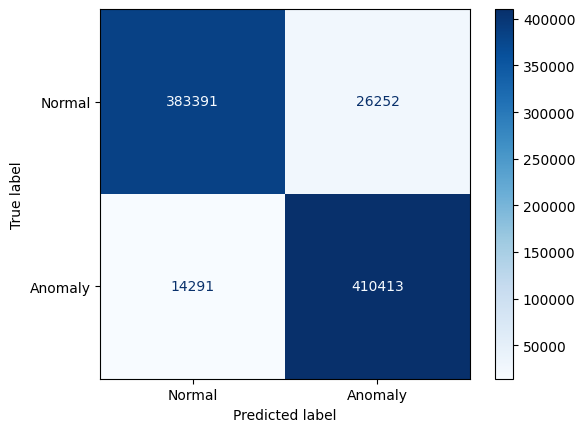

In [7]:
print("\n=== AND Voting Ensemble ===")
print(classification_report(y_test, ensemble_and))
cm = confusion_matrix(y_test, ensemble_and)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()


=== OR Voting Ensemble ===
              precision    recall  f1-score   support

         0.0       0.99      0.79      0.88    409643
         1.0       0.83      0.99      0.91    424704

    accuracy                           0.89    834347
   macro avg       0.91      0.89      0.89    834347
weighted avg       0.91      0.89      0.89    834347



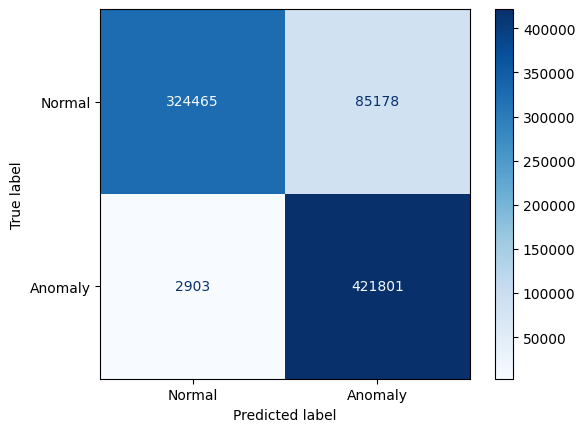

In [8]:
print("\n=== OR Voting Ensemble ===")
print(classification_report(y_test, ensemble_or))
cm_or = confusion_matrix(y_test, ensemble_or)
disp_or = ConfusionMatrixDisplay(confusion_matrix=cm_or, display_labels=["Normal", "Anomaly"])
disp_or.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

In [9]:
print(type(iso_preds_converted))
print(type(ae_preds_binary))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
# in order to correctly apply weighted average,
# we need all models to be in the same score direction and normalized (Put both scores on the same scale)
# Higher score = more anomalous

iso_scores = joblib.load(os.path.join(models_path, "iso_test_scores.pkl"))

iso_aligned = -iso_scores  #scores on test set
ae_aligned  = ae_preds    #scores on test set

# load training scores 
ae_train_scores = joblib.load(os.path.join(models_path, "ae_train_scores.pkl"))
iso_train_scores = joblib.load(os.path.join(models_path, "iso_train_scores.pkl"))

# # Percentile normalization using training scores
# ae_percentile = np.searchsorted(np.sort(ae_train_scores), ae_aligned) / len(ae_train_scores)
# iso_percentile = np.searchsorted(np.sort(-iso_train_scores), iso_aligned) / len(iso_train_scores)
# iso_percentile = np.clip(iso_percentile, 0, 0.99)  # avoids extreme top-end

from scipy.stats import rankdata

iso_percentile = rankdata(iso_aligned) / len(iso_aligned)
ae_percentile  = rankdata(ae_aligned) / len(ae_aligned)

In [41]:
w_iso = 0.6
w_ae  = 0.4
ensemble_score = w_ae * ae_percentile + w_iso * iso_percentile

In [ ]:
# find best threshold for F1 score with the weighed average ensemble scores

thresholds = np.linspace(0, 1, 500)
best_f1 = 0
best_thresh = 0
for t in thresholds:
    y_pred_temp = (ensemble_score >= t).astype(int)
    f1_temp = f1_score(y_test, y_pred_temp)
    if f1_temp > best_f1:
        best_f1 = f1_temp
        best_thresh = t

ensemble_weighted = (ensemble_score >= best_thresh).astype(int)
print("Optimal threshold:", best_thresh)
print("Best F1 score:", best_f1)

Optimal threshold: 0.4488977955911823
Best F1 score: 0.9392870061672746


=== Weighted Ensemble Report ===
              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93    409643
         1.0       0.90      0.99      0.94    424704

    accuracy                           0.94    834347
   macro avg       0.94      0.93      0.93    834347
weighted avg       0.94      0.94      0.93    834347



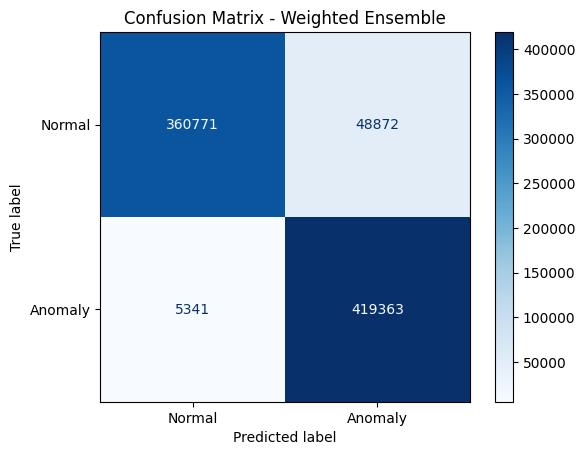

In [42]:
ensemble_weighted = (ensemble_score >= best_thresh).astype(int)     #binary 0/1 prediction
print("=== Weighted Ensemble Report ===")
print(classification_report(y_test, ensemble_weighted))

cm_weighted = confusion_matrix(y_test, ensemble_weighted)
disp_weighted = ConfusionMatrixDisplay(confusion_matrix=cm_weighted, display_labels=["Normal", "Anomaly"])
disp_weighted.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Weighted Ensemble")
plt.show()

In [43]:
from sklearn.metrics import classification_report
print("Isolation Forest report:\n", classification_report(y_test, iso_preds_converted))
print("Autoencoder report:\n", classification_report(y_test, ae_preds_binary))

Isolation Forest report:
               precision    recall  f1-score   support

         0.0       0.96      0.93      0.95    409643
         1.0       0.93      0.97      0.95    424704

    accuracy                           0.95    834347
   macro avg       0.95      0.95      0.95    834347
weighted avg       0.95      0.95      0.95    834347

Autoencoder report:
               precision    recall  f1-score   support

         0.0       0.99      0.80      0.88    409643
         1.0       0.84      0.99      0.91    424704

    accuracy                           0.90    834347
   macro avg       0.91      0.90      0.90    834347
weighted avg       0.91      0.90      0.90    834347



In [47]:
ensemble_df = pd.DataFrame({
    "y_true": y_test,
    "iso_preds": iso_preds_converted,
    "ae_preds": ae_preds_binary,
    "AND": ensemble_and,
    "OR": ensemble_or,
    "Weighted": ensemble_weighted,
    "Weighted_score": ensemble_score,
    "iso_score": iso_percentile,
    "ae_score": ae_percentile,
    "iso_contrib": (w_iso * iso_percentile) / ensemble_score,
    "ae_contrib": (w_ae * ae_percentile) / ensemble_score
})

In [48]:
ensemble_df["iso_correct"] = (ensemble_df["iso_preds"] == ensemble_df["y_true"]).astype(int)
ensemble_df["ae_correct"]  = (ensemble_df["ae_preds"] == ensemble_df["y_true"]).astype(int)
ensemble_df["AND_correct"] = (ensemble_df["AND"] == ensemble_df["y_true"]).astype(int)
ensemble_df["OR_correct"]  = (ensemble_df["OR"] == ensemble_df["y_true"]).astype(int)
ensemble_df["Weighted_correct"] = (ensemble_df["Weighted"] == ensemble_df["y_true"]).astype(int)

In [49]:
ensemble_df.to_pickle(os.path.join(processed_path, "ensemble_preds.pkl"))
ensemble_df.to_csv(os.path.join(processed_path, "ensemble_preds.csv"), index=False)